# Introduction

- The project was accomplished by employing supervised learning, ensemble modeling, and unsupervised learning techniques to build and train a prediction model to identify Pass/Fail yield of a particular process entity for a semiconductor manufacturing company.
- This project helps to determine key factors contributing to yield excursions downstream in the process and will enable an increase in process throughput, decreased time to learn and reduce per-unit production costs.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import and understand the data.

### Q1. A. Import ‘signal-data.csv’ as DataFrame

In [ ]:
d1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project_Data/signal-data.csv")
d1.head(1)

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.0,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.363,NaN,NaN,NaN,NaN,-1


### Q1. B. Print 5 point summary and share at least 2 observations.

In [ ]:
d1.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1561.0,3014.452896,73.621787,2743.2400,2966.260000,3011.4900,3056.6500,3356.3500
1,1560.0,2495.850231,80.407705,2158.7500,2452.247500,2499.4050,2538.8225,2846.4400
2,1553.0,2200.547318,29.513152,2060.6600,2181.044400,2201.0667,2218.0555,2315.2667
3,1553.0,1396.376627,441.691640,0.0000,1081.875800,1285.2144,1591.2235,3715.0417
4,1553.0,4.197013,56.355540,0.6815,1.017700,1.3168,1.5257,1114.5366
...,...,...,...,...,...,...,...,...
586,1566.0,0.021458,0.012358,-0.0169,0.013425,0.0205,0.0276,0.1028
587,1566.0,0.016475,0.008808,0.0032,0.010600,0.0148,0.0203,0.0799
588,1566.0,0.005283,0.002867,0.0010,0.003300,0.0046,0.0064,0.0286
589,1566.0,99.670066,93.891919,0.0000,44.368600,71.9005,114.7497,737.3048


**Observations :**
- There are null values in many columns.
- Feature scaling is required. Because the data range varies a lot for all the columns.
- Number of features is large So feature reduction will be required.
- Column Names are not intutive. So we will have to depend on feature engineering techniques such as Lasso or PCA for feature reduction.
- Verifing colinearity is also important to decide on the important features to be kept.
- For few features like 4, outlier exists and the outlier have large values. So there is difference in Mean and Median values.

## 2. Data cleansing:

In [ ]:
d1.isnull().sum()

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

### Q2. A. Write a for loop which will remove all the features with 20%+ Null values and impute rest with mean of the feature.

In [ ]:
print("Shape of the original dataset : ",d1.shape)

# Find the 20% of the whole dataset size
threshold = round(d1.shape[0] * 0.2)
print("\n20% of all records : ", threshold)

# Find the records which has NULL values more than 20% threshold
sNull = d1.isnull().sum()
cols_to_drop = sNull[sNull >= threshold]
col_names = cols_to_drop.index

print("\nNumber of columns to drop : ", len(col_names))
print("\nList of columns to drop with NULL value count : \n", dict(zip(cols_to_drop.index,cols_to_drop.values)))

# Drop the columns which has more than 20% values as NULL
d1.drop(columns=col_names,inplace=True)
print("\nShape of the dataset after dropping the columns : ", d1.shape)

Shape of the original dataset :  (1567, 592)

20% of all records :  313

Number of columns to drop :  32

List of columns to drop with NULL value count : 
 {'72': 794, '73': 794, '85': 1341, '109': 1018, '110': 1018, '111': 1018, '112': 715, '157': 1429, '158': 1429, '220': 1341, '244': 1018, '245': 1018, '246': 1018, '247': 715, '292': 1429, '293': 1429, '345': 794, '346': 794, '358': 1341, '382': 1018, '383': 1018, '384': 1018, '385': 715, '492': 1341, '516': 1018, '517': 1018, '518': 1018, '519': 715, '578': 949, '579': 949, '580': 949, '581': 949}

Shape of the dataset after dropping the columns :  (1567, 560)


### Drop "Time" column

In [ ]:
# Drop the timestamp column
d1.drop(['Time'],axis=1,inplace = True)
print("\nShape of the dataset after dropping timestamp column : ", d1.shape)


Shape of the dataset after dropping timestamp column :  (1567, 559)


### Q2. C. Drop other features if required using relevant functional knowledge. Clearly justify the same.

In [ ]:
if d1.duplicated().sum() == 0:
  print("There are no duplicate records.")

There are no duplicate records.


In [ ]:
print("Number of duplicate columns : ",d1.T.duplicated().sum())
d1 = d1.T.drop_duplicates().T
print("Shape of dataset after removing duplicate columns : ",d1.shape)

Number of duplicate columns :  104
Shape of dataset after removing duplicate columns :  (1567, 455)


### Q2. B. Identify and drop the features which are having same value for all the rows.

In [ ]:
same_value_columns = d1.columns[d1.nunique() == 1]
d1.drop(same_value_columns, inplace=True,axis=1)

### Q2. D D. Check for multi-collinearity in the data and take necessary action.

In [ ]:
corr_matrix = pd.DataFrame(d1).corr().abs()
ls_than_one = (pd.DataFrame((corr_matrix < 1) & (corr_matrix != 1))).sum().sum()
gr_than_nine = (pd.DataFrame((corr_matrix > 0.9) & (corr_matrix != 1))).sum().sum()
gr_than_eight = (pd.DataFrame((corr_matrix > 0.8) & (corr_matrix != 1))).sum().sum()
gr_than_seven = (pd.DataFrame((corr_matrix > 0.7) & (corr_matrix != 1))).sum().sum()

print("Number of correlation coefficients :  ", corr_matrix.size)
print("Number of correlation coefficients which are less than one:  ", ls_than_one)
print("Number of correlation coefficients which are greater than 0.9:  ", gr_than_nine)
print("Number of correlation coefficients which are greater than 0.8:  ", gr_than_eight)
print("Number of correlation coefficients which are greater than 0.7:  ", gr_than_seven)

Number of correlation coefficients :   196249
Number of correlation coefficients which are less than one:   195788
Number of correlation coefficients which are greater than 0.9:   698
Number of correlation coefficients which are greater than 0.8:   1184
Number of correlation coefficients which are greater than 0.7:   1530


**Note :**
- There are many features which are highly collinear.
- Many algorithams such as,  Logistic Regression, KNN etc. are affected by multicollinearity. They perform  poorly on multicollinear data. So it important to remove multicollinearity.
- But removing multicollinear features can also result in loss of information.
- Considering the large feature size, to reduce the number of features and avoid loss of information, let us use another feature engineering technique - PCA.
- PCA would be applied in following sections. Code block number : ...

### Q2. E. Make all relevant modifications on the data using both functional/logical reasoning/assumptions

Impute NULL values with median of the respective feature

In [ ]:
print("Number of NULL values in the dataset : ", d1.isnull().sum().sum())

Number of NULL values in the dataset :  8008


In [ ]:
for c in d1.columns:
  med = d1[c].median()
  d1[c].replace(np.nan,med,inplace=True)

In [ ]:
print("Number of NULL values in the dataset : ", d1.isnull().sum().sum())

Number of NULL values in the dataset :  0


Check for non-numric columns

In [ ]:
non_numeric_columns = d1.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:")
print(non_numeric_columns)
print("Number of non-numeric columns:", len(non_numeric_columns))

Non-numeric columns:
Index([], dtype='object')
Number of non-numeric columns: 0


Convert Pass/Fail feature to "Categorical" type

In [ ]:
d1['Pass/Fail']=d1['Pass/Fail'].astype("category")

**Observations :**
- There were 590 features, excludng Time and Pass/Fail features.
- It has been reduced to 443 after following the steps below:
  - Removed duplicate features
  - Removed features with 20% NULL values
  - Removed features having same value for all rows
- There were many NULL values. They have been replaced with median of respective feature.
- Out of 443 features, many features are correlated.
- But  instead of removing the collinear features, let us apply PCA to avoid major loss of information.
- The output column has been changed to a Category type. It is required for EDA to use the feature as Categorical variable.

## 3. Data analysis & visualisation

### Q3. A. Perform a detailed univariate Analysis with appropriate detailed comments after each analysis

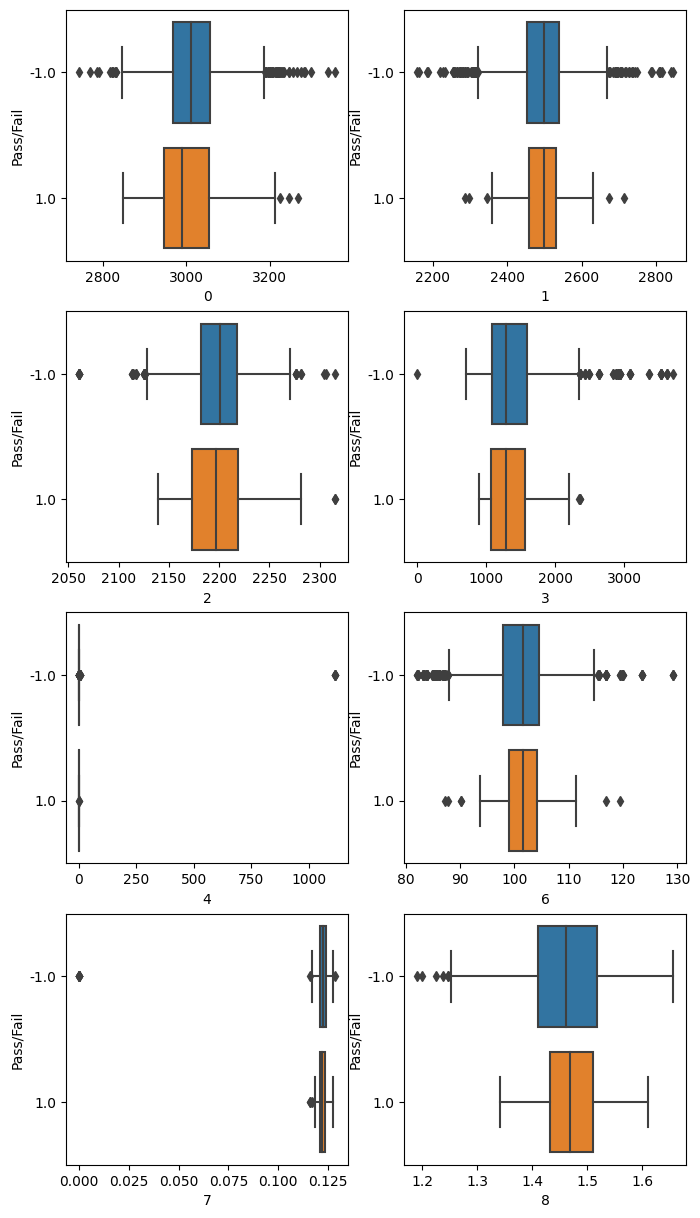

In [ ]:
f, ax = plt.subplots(4, 2, figsize=(8,15))    #12, 16
index=0
for i in range(4):
  for j in range(2):
    col = d1.columns[index]
    index += 1
    sns.boxplot(  x= col, data=d1,  ax=ax[i,j], y='Pass/Fail')

**Note :**

- There are many outliers for most of the features.
- The data for both classes (pass / Fail) overlaps. There is no clear distinction of values for the two output classes.

Remove the outliers from the box plot, to analyze distribution of data for the 2 categories.

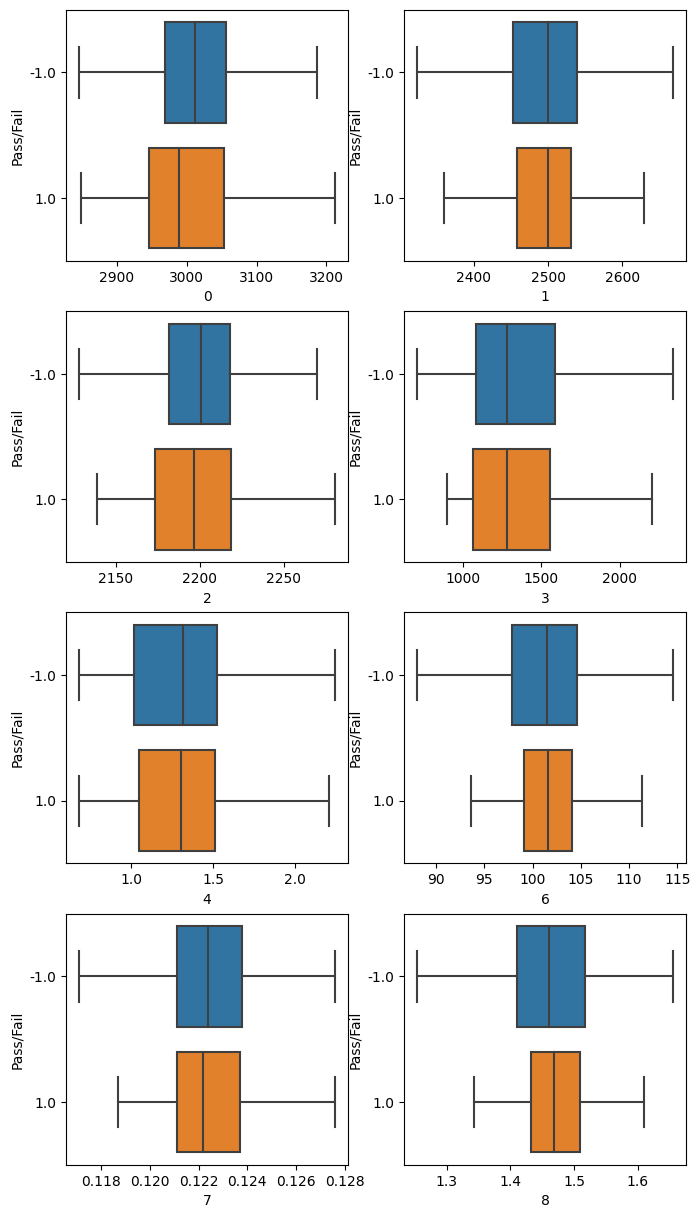

In [ ]:
f, ax = plt.subplots(4, 2, figsize=(8,15))    #12, 16
index=0
for i in range(4):
  for j in range(2):
    col = d1.columns[index]
    index += 1
    sns.boxplot(  x= col, data=d1,  ax=ax[i,j], y='Pass/Fail', showfliers=False)

**Note :**
- The data overlaps for most of features.
- It won't be linearly seperable.
- Non-linear models would perform well for such type of data.

### Q3. B. Perform bivariate and multivariate analysis with appropriate detailed comments after each analysis. [

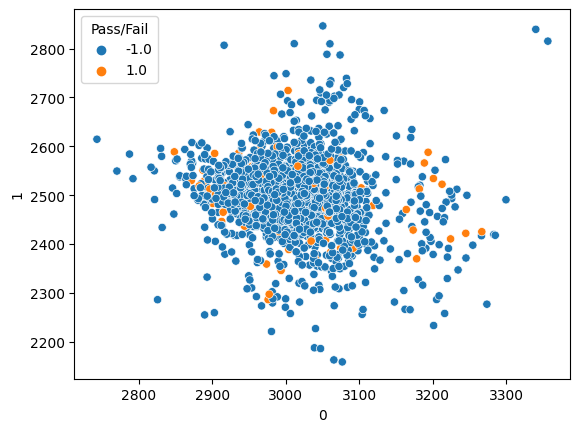

In [ ]:
sns.scatterplot(data=d1,x="0", y="1",hue='Pass/Fail');

In [ ]:
d1['Pass/Fail'].value_counts()

-1.0    1463
1.0      104
Name: Pass/Fail, dtype: int64

**Note :**
- Data is highly imbalanced
- There are very less data points with output as "Fail"

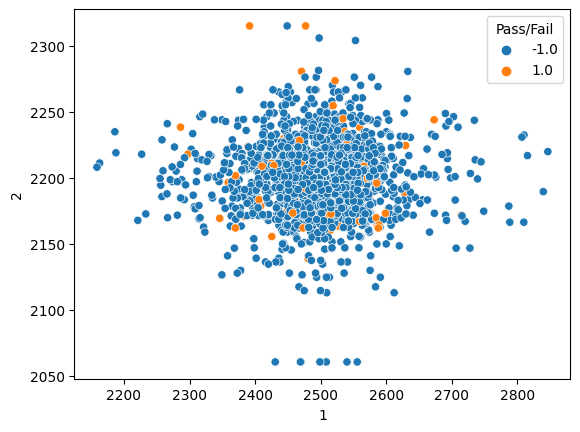

In [ ]:
sns.scatterplot(data=d1,x="1", y="2", hue="Pass/Fail");

**Note :**
- As observed in the box plot, the data for both the classes is ovelapping.
- It is not linearly seperable.

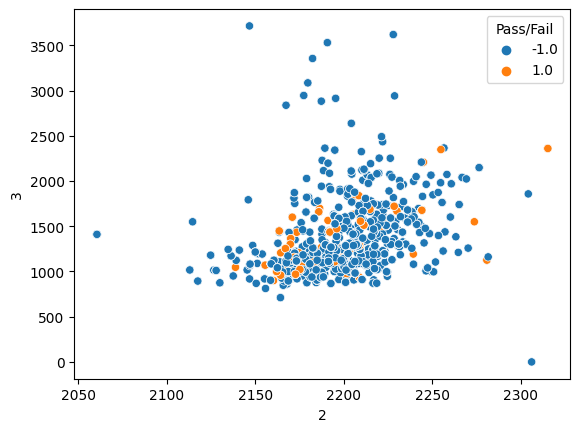

In [ ]:
sns.scatterplot(data=d1,x="2", y="3", hue="Pass/Fail");
# plt.legend([],[], frameon=False)                    # To hide the Legend box

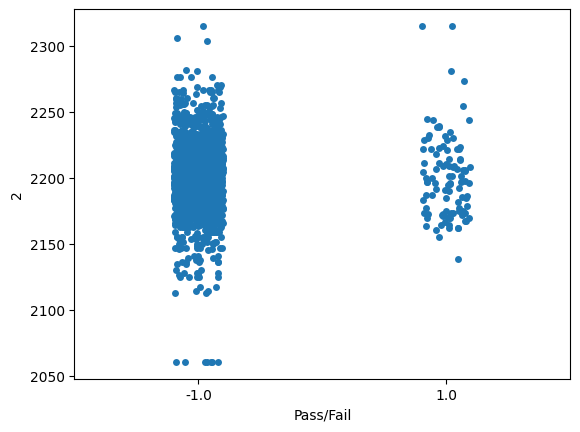

In [ ]:
sns.stripplot(data=d1, x="Pass/Fail", y="2");

- Data is imbalanced.
- "Fail" cases are low, so the model will be baised towards majority class i.e. "Pass".

## 4. Data pre-processing:

### Q4 A - Segregate predictors vs target attributes.

In [ ]:
# independant variables
X = d1.iloc[:,:-1]
# the dependent variable
y = d1.iloc[:,-1]

### Q4. C. Perform train-test split and standardise the data or vice versa if required.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,stratify = y, random_state = 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1253, 442), (314, 442), (1253,), (314,))

In [ ]:
# Use StandardScaler

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

### Q4. D. Check if the train and test data have similar statistical characteristics when compared with original data.

In [ ]:
print("Class distribution for original data : \n" , d1['Pass/Fail'].value_counts())
print("\nClass distribution for training data : \n" , y_train.value_counts())
print("\nClass distribution for test data  : \n" , y_test.value_counts())
print("\nClass distribution for original data (in percentage) : \n" , np.round(d1['Pass/Fail'].value_counts() / len(d1['Pass/Fail']),2) * 100)
print("\nClass distribution for training data (in percentage) : \n" , np.round(y_train.value_counts() / len(y_train),2) * 100)
print("\nClass distribution for test data (in percentage) : \n" , np.round(y_test.value_counts()  / len(y_test),2) * 100)

Class distribution for original data : 
 -1.0    1463
1.0      104
Name: Pass/Fail, dtype: int64

Class distribution for training data : 
 -1.0    1170
1.0       83
Name: Pass/Fail, dtype: int64

Class distribution for test data  : 
 -1.0    293
1.0      21
Name: Pass/Fail, dtype: int64

Class distribution for original data (in percentage) : 
 -1.0    93.0
1.0      7.0
Name: Pass/Fail, dtype: float64

Class distribution for training data (in percentage) : 
 -1.0    93.0
1.0      7.0
Name: Pass/Fail, dtype: float64

Class distribution for test data (in percentage) : 
 -1.0    93.0
1.0      7.0
Name: Pass/Fail, dtype: float64


- "stratify" parameter of "train_test_split()" function is used.
- It splited the data into training set and test set, in such a way that the ratio of both the classes is same in all the 3 datasets - original, training and test datasets





### Q2. D. (Check for Multicollinearity)  Let us apply PCA (130 components)

As mentioned in Q2. D., instead of removing features which are highly correlated, let us apply PCA and find the top PCA components which will cover 90% of variance in the data.

In [ ]:
pca = PCA(n_components=130)
pca.fit(X_train)

# Check whether it covers 90% of cumulative variance
print("Cumulative variance : ", pca.explained_variance_ratio_.sum().round(2))

# Transform the data to a new basis
X_train = pd.DataFrame(pca.transform(X_train))

# Transform the test data as well
X_test = pd.DataFrame(pca.transform(X_test))

Cumulative variance :  0.91


### Temeporary code - Copy of training data

In [ ]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

In [ ]:
X_train = X_train_copy.copy()
y_train = y_train_copy.copy()

### q4. B. Check for target balancing and fix it if found imbalanced.

- In Q4. D., we can clearing see that the data is imbalnced (93% vs 7%). So target needs to be balanced.

#### 1. Random Sampling

In [ ]:
# Combine X_train and y_train
y_train.reset_index(inplace=True, drop=True)
combined_train_data = X_train.join(y_train)

In [ ]:
from collections import Counter

iterations = 2

print('Original dataset shape', Counter(y_train))

for i in range(iterations):
  extra_samples = combined_train_data[combined_train_data['Pass/Fail'] == 1].sample(n = 83, random_state = 1)
  X_train = pd.concat([X_train, extra_samples.drop(columns='Pass/Fail')])
  y_train = pd.concat([pd.Series(y_train), extra_samples['Pass/Fail']])

print('Resample dataset shape', Counter(y_train))

Original dataset shape Counter({-1.0: 1170, 1.0: 83})
Resample dataset shape Counter({-1.0: 1170, 1.0: 249})


- This sampling technique seems to give better results.

## 5. Model training, testing and tuning:

Common Function :-

In [ ]:
from sklearn.metrics import confusion_matrix

def ShowResults(y_p,y_predicted_p):
  print(metrics.confusion_matrix(y_p,y_predicted_p))
  print(metrics.classification_report(y_p,y_predicted_p))


def PrintScoreMetrics(model, ShowConfusionMatrix = False, AddToScoreList = True, ModelName=None):
  train_acc = model.score(X_train, y_train)
  test_acc = model.score(X_test, y_test)

  #Predicting on train and tests
  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)
  train_recall = metrics.recall_score(y_train,pred_train)
  test_recall = metrics.recall_score(y_test,pred_test)

  print("Training accuracy : ", train_acc)
  print("Test accuracy : ", test_acc, "\n")
  print("Training recall : " , train_recall)
  print("Test recall : " , test_recall,"\n")

  if (ShowConfusionMatrix):
    cm = confusion_matrix(y_test, pred_test, labels=[-1, 1])
    df_cm = pd.DataFrame(cm, index = ["Pass","Fail"], columns = ["Pass","Fail"])
    plt.figure(figsize = (2,1))
    sns.heatmap(df_cm, annot=True ,fmt='g')

Q5. A. Use any Supervised Learning technique to train a model.

- The data does not seem to be linearly seperable.
- So lets try a non-linear algorithm. Let's use KNN.

### Q5. C. Apply hyper-parameter tuning techniques to get the best accuracy.

- Need to find the best value for "k" - number of nearest neighbours.
- Let evaluate result for various values of "k" and print te results plot, to identify te best value.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
scores =[]
for k in range(2,25):
    NNH = KNeighborsClassifier(n_neighbors = k, weights = 'distance' )
    NNH.fit(X_train, y_train)
    pred_test = NNH.predict(X_test)
    scores.append(metrics.recall_score(y_test,pred_test))

fig = px.line(x=range(2,25), y=scores, width=600, height=300)
fig.show()

The above plot is not visible in HTML, so lets plot it again using seaborn library

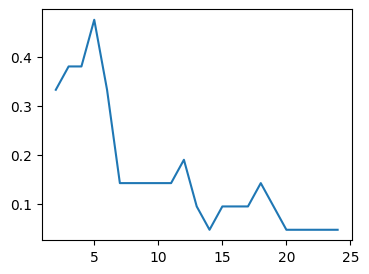

In [ ]:
plt.figure(figsize=(4, 3))
sns.lineplot(x=range(2,25), y=scores, errorbar=('ci', False));

**Note :**
- The best value of "k" is 5.
- **recall - 48%**

### Q5. A. Use any Supervised Learning technique to train a model.

In [ ]:
NNH = KNeighborsClassifier(n_neighbors = 5, weights = 'distance' )
NNH.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

### Q5. E. Display and explain the classification report in detail.

Training accuracy :  1.0
Test accuracy :  0.8407643312101911 

Training recall :  1.0
Test recall :  0.47619047619047616 

[[254  39]
 [ 11  10]]
              precision    recall  f1-score   support

        -1.0       0.96      0.87      0.91       293
         1.0       0.20      0.48      0.29        21

    accuracy                           0.84       314
   macro avg       0.58      0.67      0.60       314
weighted avg       0.91      0.84      0.87       314



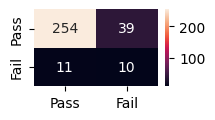

In [ ]:
PrintScoreMetrics(NNH, True)
y_predicted = NNH.predict(X_test)
ShowResults(y_test, y_predicted)

**Observations :**
- The best hyperparameter **k=5** has scored:
  - Recall : **48%**
  - Precision : **20%**
  - Accuracy : **84%**

### Q5. B. Use cross validation techniques

In [ ]:
from sklearn.model_selection import cross_val_score

k_range=range(2,25)
k_scores=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,X_train,y_train,cv=10,scoring='recall')
    k_scores.append(scores.mean())

In [ ]:
print(f"Maximum recall rate({max(k_scores).round(2)}) is for K = {k_scores.index(max(k_scores))+2}\n")

results = [(index + 2, value.round(2)) for index, value in enumerate(k_scores) if value > 0.9]
print(pd.DataFrame(results,columns=["k","Score"]))

Maximum recall rate(0.98) is for K = 2

   k  Score
0  2   0.98
1  3   0.98


- For k=2 & 3, recall rate is 98%

### Q5. C. Apply hyper-parameter tuning techniques to get the best accuracy.

In [ ]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

# Define the hyperparameter grid for tuning
param_grid = {
    'n_neighbors': np.arange(2, 25),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='recall', n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

y_predicted = best_model.predict(X_test)
print("Test recall:", metrics.recall_score(y_test,y_predicted).round(2))
print("Test precision:", metrics.precision_score(y_test,y_predicted).round(2))
print("Test accuracy:", metrics.accuracy_score(y_test,y_predicted).round(2))

Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Test recall: 0.33
Test precision: 0.33
Test accuracy: 0.91


### Q5. D. Use any other technique/method which can enhance the model performance.

- We have already done :
  - Dimensionality reduction (using PCA)
  - Attribute removal (in Data cleansing section)
  - Standardisation (used StandardScaler)
  - Target balancing (used random sampling)
- We have got best hyperparameter k as "5"

- Now let us check the ROC curve and AUC (Area Under the Curve), to analyze how the model performance.
  - Let us check the best threshold value.

In [ ]:
predicted_probs = NNH.predict_proba(X_test)

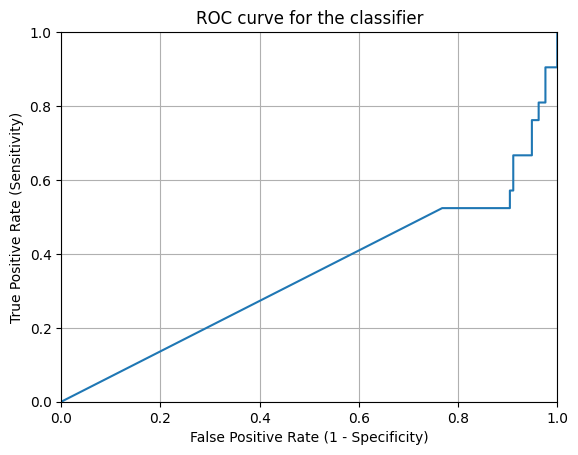

In [ ]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_probs[:,0])
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve for the classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
print("AUC : ", metrics.roc_auc_score(y_test, predicted_probs[:,1]))

AUC :  0.6553713635624898


- AUC is **65%**

Let us check the performance for different threshold values

In [ ]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [ ]:
# Find the best threshold
evaluate_threshold(0.3)

Sensitivity: 0.9047619047619048
Specificity: 0.023890784982935176


In [ ]:
evaluate_threshold(0.5)

Sensitivity: 0.5238095238095238
Specificity: 0.23208191126279865


### 10. Predict on Test data using the Threshold. Check accuracy, Recall & Precision.

In [ ]:
from sklearn.preprocessing import binarize
y_pred_class = pd.Series(binarize([predicted_probs[:,1]], threshold=0.3)[0])
y_pred_class.replace(0,-1,inplace=True)
ShowResults(y_test, y_pred_class)

[[240  53]
 [ 11  10]]
              precision    recall  f1-score   support

        -1.0       0.96      0.82      0.88       293
         1.0       0.16      0.48      0.24        21

    accuracy                           0.80       314
   macro avg       0.56      0.65      0.56       314
weighted avg       0.90      0.80      0.84       314



**Note :**
- Reducing the threshold value is not improving the recall rate **48%**, but lowering the precision value from **20% to 16%**
- So threshold should not be changed. The threshold value of **0.5** is optimum in this case.

### Q5. F. Apply the above steps for all possible models that you have learnt so far

Common Functions:

In [ ]:
from IPython.display import display, HTML

score_list = set()

def SaveResult(model,title):
  pred_test = model.predict(X_test)
  test_recall = metrics.recall_score(y_test,pred_test).round(2)
  test_precision = metrics.precision_score(y_test,pred_test).round(2)
  test_accuracy = metrics.accuracy_score(y_test,pred_test).round(2)
  print("Recall : {}\nPrecision : {}\nAccuracy : {}".format(test_recall,test_precision,test_accuracy))

  score_list.add((title,test_recall,test_precision,test_accuracy))

def ShowScores():
  df = pd.DataFrame(score_list, columns=['Title','Recall','Precison','Accuracy']).to_html()
  display(HTML(df))

Let us analyze the data using various models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
m = LogisticRegression(solver="liblinear")
m.fit(X_train, y_train)
SaveResult(m,"Logistic Regression")

Recall : 0.14
Precision : 0.1
Accuracy : 0.86


In [ ]:
m = SVC(class_weight='balanced', probability=True)            # kernel='sigmoid'
m.fit(X_train, y_train)
SaveResult(m,"SVM")

Recall : 0.24
Precision : 0.42
Accuracy : 0.93


In [ ]:
m = DecisionTreeClassifier()
m.fit(X_train,y_train)
SaveResult(m,"Decision Tree")

Recall : 0.05
Precision : 0.08
Accuracy : 0.9


In [ ]:
import warnings

with warnings.catch_warnings():
  warnings.filterwarnings("ignore")         # Divide by zero
  m = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1)
  m.fit(X_train, y_train)
  SaveResult(m,"Random Forest")

Recall : 0.0
Precision : 0.0
Accuracy : 0.93


In [ ]:
m = AdaBoostClassifier()
m.fit(X_train, y_train)
SaveResult(m,"Ada Boost")

Recall : 0.14
Precision : 0.14
Accuracy : 0.88


In [ ]:
m = GradientBoostingClassifier()
m.fit(X_train, y_train)
SaveResult(m,"Gradient Boosting")

Recall : 0.05
Precision : 0.25
Accuracy : 0.93


In [ ]:
m = KNeighborsClassifier(n_neighbors = 5, weights = 'distance' )
m.fit(X_train, y_train)
SaveResult(m,"KNN (k=5)")

Recall : 0.48
Precision : 0.2
Accuracy : 0.84


In [ ]:
m = KNeighborsClassifier(metric =  'euclidean', n_neighbors =  2, weights = 'distance')
m.fit(X_train, y_train)
SaveResult(m,"KNN (k=2)")

Recall : 0.33
Precision : 0.33
Accuracy : 0.91


## 6. Post Training and Conclusion:

### Q6. A. Display and compare all the models designed with their train and test accuracies.

In [ ]:
ShowScores()

,Title,Recall,Precison,Accuracy
0,Ada Boost,0.14,0.14,0.88
1,SVM,0.24,0.42,0.93
2,KNN (k=5),0.48,0.20,0.84
3,KNN (k=2),0.33,0.33,0.91
4,Logistic Regression,0.14,0.10,0.86
5,Decision Tree,0.05,0.08,0.90
6,Random Forest,0.00,0.00,0.93
7,Gradient Boosting,0.05,0.25,0.93


**Note :**
- KNN seems to be the best algorithm here
  - For k = 2
  - For k = 5

### Q6. B. Select the final best trained model along with your detailed comments for selecting this model.

In [ ]:
model = KNeighborsClassifier(n_neighbors = 5, weights = 'distance' )
model.fit(X_train, y_train)
SaveResult(model,"KNN (k=5)")

Recall : 0.48
Precision : 0.2
Accuracy : 0.84


**Note :**
- Here, it is important to identify the Failed cases. These cases would help the organization to improve the manufacturing process.
  -  So "Recall" rate is important here.
- Frequency of Failed cases is low as compared to the Passed cases. It means the class of interest is in minority.  
  - So it essential to resample the data to balnce the class ratio.
- As we tune the model to increase "Recall" rate, the "Precesion" goes down. i.e. while giving importance to the class of interest, False predictions increase. It is needed to balance the "Recall" and "Precision" rates, while keeping the interest intact.
  - Considering these facts, **"KNN (k=5)"** seems to have performed well on the above measures.
    - Recall : **48%**
    - Precision : **20%**
    - Accuracy : **84%**



### Q6. C. Pickle the selected model for future use.

In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "/content/drive/MyDrive/Colab Notebooks/Project_Data/SavedModel_KNN.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)

Reference:
https://neptune.ai/blog/saving-trained-model-in-python

Test the saved model

In [ ]:
with open(model_pkl_file, 'rb') as file:
    loaded_model = pickle.load(file)

# evaluate model
y_predict = loaded_model.predict(X_test)

# check results
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

        -1.0       0.96      0.87      0.91       293
         1.0       0.20      0.48      0.29        21

    accuracy                           0.84       314
   macro avg       0.58      0.67      0.60       314
weighted avg       0.91      0.84      0.87       314



### 6. D. Write your conclusion on the results.

- Number of features is large. So finding the important features is important.
- Pre-processing step (Data cleansing) plays a crucial role here. Because removing the irrelevant features while preserving the useful information is vital for building high performing model.
- Choosing the right perfomance metrics is also important while measuring the performance of the model. e.g. here, failed cases are of more importance than the passed cases. So "recall" rate is given more value than the "accuracy".
- Data is overlapping, not linearly seperable. So it is difficult to differenciate between the classes. Data cleansing is important to remove the noise and irrelevent information from the data.